In [1]:
# Code by Francois Aguet modified by Yanyu Liang
import pandas as pd
import numpy as np
import scipy.stats as stats
import torch

In [2]:
# load tensorqtl scripts
import sys, os, gzip
sys.path.insert(0, '/Users/yanyul/Documents/repo/github/tensorqtl/tensorqtl')

import tensorqtl
from tensorqtl import cis
from tensorqtl import mixqtl

In [3]:
# the code has been pushed to my fork tensorqtl
# # load mixQTL.py by Francois
# sys.path.insert(0, '/Users/yanyul/Desktop/tmp/tensorqtl_test/')
# import mixqtl
# from importlib import reload 
# mixqtl = reload(mixqtl)

# Data pointers

In [4]:
datadir = '/Users/yanyul/Desktop/tmp/GEUVADIS-mixqtl'

# genotypes
vcf = f'{datadir}/GEUVADIS.chr22.PH1PH2_465.IMPFRQFILT_BIALLELIC_PH.annotv2.genotypes.vcf.gz'
hap1_file = f'{datadir}/tempo-GEUVADIS.chr22.PH1PH2_465.IMPFRQFILT_BIALLELIC_PH.annotv2.genotypes.hap1.parquet'
hap2_file = f'{datadir}/tempo-GEUVADIS.chr22.PH1PH2_465.IMPFRQFILT_BIALLELIC_PH.annotv2.genotypes.hap2.parquet'

# total count matrix
trc_file = f'{datadir}/geuvadis.total_count.bed.gz'

# allele-specific count matrix
asc1_file = f'{datadir}/geuvadis.asc.h1.tsv.gz'
asc2_file = f'{datadir}/geuvadis.asc.h2.tsv.gz'

# library size
lib_file = f'{datadir}/geuvadis.library_size.tsv.gz'

# covariate matrix
covar_file = f'{datadir}/geuvadis.covariate.txt.gz'

# output prefix
output_prefix = 'geuvadis.mixqtl_run_trc'

# a reference eqtl result
eqtl_reference = '/Users/yanyul/Downloads/EUR373.gene.cis.FDR5.all.rs137.txt.gz'

# Load genotypes

In [5]:
# load genotypes
# convert vcf gz to parquet for fast access in future runs
if not (os.path.isfile(hap1_file) and os.path.isfile(hap2_file)):
    gt_dict = {'0':np.int8(0), '1':np.int8(1), '.':np.int8(-1)}

    with gzip.open(vcf, 'rt') as f:
        variant_ids = []
        hap1 = []
        hap2 = []
        for line in f:
            if line.startswith('##'):
                continue
            break
        sample_ids = line.strip().split('\t')[9:]

        # read first line, parse field
        line = f.readline().strip().split('\t')
        gt_ix = line[8].split(':').index('GT')
        variant_ids.append(line[2])
        d = [i.split(':')[gt_ix].split('|') if len(i.split(':')[gt_ix].split('|')) == 2 else ['.', '.'] for i in line[9:]]
        hap1.append(np.array([gt_dict[i[0]] for i in d]))
        hap2.append(np.array([gt_dict[i[1]] for i in d]))

        for k,line in enumerate(f,2):
            line = line.strip().split('\t')
            variant_ids.append(line[2])
            d = [i.split(':')[gt_ix].split('|') if len(i.split(':')[gt_ix].split('|')) == 2 else ['.', '.'] for i in line[9:]]
            hap1.append(np.array([gt_dict[i[0]] for i in d]))
            hap2.append(np.array([gt_dict[i[1]] for i in d]))

            if np.mod(k,1000)==0:
                print('\rVariants parsed: {}'.format(k), end='')
                
    hap1_df = pd.DataFrame(np.array(hap1), index=variant_ids, columns=sample_ids)
    hap1_df.to_parquet(hap1_file)  # , engine='fastparquet')

    hap2_df = pd.DataFrame(np.array(hap2), index=variant_ids, columns=sample_ids)
    hap2_df.to_parquet(hap2_file)  # , engine='fastparquet')

hap1_df = pd.read_parquet(hap1_file)
hap2_df = pd.read_parquet(hap2_file)
variant_df = pd.DataFrame({'chrom':hap1_df.index.map(lambda x: 'chr' + x.split('_')[1]),
                           'pos':  hap1_df.index.map(lambda x: int(x.split('_')[2]))}, index=hap1_df.index)

# Load total counts

In [6]:
def trc_qc(df, pos_df, threshold = 100, min_obs = 50):
    t__ = df >= threshold
    npass = t__.sum(axis = 1)
    df = df.loc[npass >= min_obs, :]
    pos_df = pos_df.loc[npass >= min_obs, :]
    return df, pos_df

In [7]:
phenotype_df, phenotype_pos_df = tensorqtl.read_phenotype_bed(trc_file)
phenotype_df, phenotype_pos_df = trc_qc(phenotype_df, phenotype_pos_df)
libsize_df = pd.read_csv(lib_file, header = 0, sep = '\t', compression = 'gzip')
libsize_df = libsize_df.set_index('indiv')
libsize_s = libsize_df.loc[phenotype_df.columns.tolist(), 'lib_size']

In [8]:
# compute log(count / libsize)
log_counts_df = np.log(phenotype_df / libsize_s / 2)
log_counts_df = log_counts_df.loc[phenotype_df.index]
log_counts_df[log_counts_df == -np.Inf] = np.NaN
# counts_df = counts_df.loc[phenotype_df.index]

/Users/yanyul/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


# Load fake allele-specific counts

In [9]:
ref_df = pd.read_csv(asc1_file, header = 0, sep = '\t', compression = 'gzip')
ref_df = ref_df.set_index('gene_list')
alt_df = pd.read_csv(asc2_file, header = 0, sep = '\t', compression = 'gzip')
alt_df = alt_df.set_index('gene_list')

# Load covariates

In [10]:
covariates_df = pd.read_csv(covar_file, sep = '\t', index_col = 0, compression = 'gzip').T
covariates_df = covariates_df.loc[phenotype_df.columns.to_list(), :]

# Run trcQTL

In [11]:
# map only chr1 for tests:
ix = phenotype_pos_df[phenotype_pos_df['chr']=='chr22'].index
mixqtl.map_nominal(hap1_df, hap2_df, variant_df, 
                   log_counts_df.loc[ix], phenotype_df.loc[ix], ref_df.loc[ix], alt_df.loc[ix],
                   phenotype_pos_df.loc[ix], covariates_df, output_prefix,
                   output_dir=f'{datadir}/', verbose=True)

cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 462 samples
  * 403 phenotypes
  * 26 covariates
  * 493859 variants
  * checking phenotypes: 403/403
  * Computing associations
    Mapping chromosome chr22
    processing phenotype 403/403
    time elapsed: 6.81 min


/Users/yanyul/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/yanyul/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/yanyul/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


    * writing output
done.


# Results

In [12]:
pval_df = pd.read_parquet(f'{datadir}/{output_prefix}.cis_qtl_pairs.mixQTL.chr22.parquet')

In [13]:
df = pval_df.loc[pval_df['maf_trc'] > 0.01].iloc[:, :10]

In [14]:
# load eqtl results on EUR (by 1000G eQTL paper)
df_ref = pd.read_csv(eqtl_reference, header = 0, compression = 'gzip', sep = '\t')

In [15]:
df_ref.loc[df_ref['CHR_SNP'] == 22]

,SNP_ID,ID,GENE_ID,PROBE_ID,CHR_SNP,CHR_GENE,SNPpos,TSSpos,distance,rvalue,pvalue,log10pvalue
407207,rs4275,-,ENSG00000260065.1,ENSG00000260065.1,22,22,26921725.0,26921002,723.0,0.767814,1.809164e-73,72.742522
407208,rs71311575,-,ENSG00000260065.1,ENSG00000260065.1,22,22,26919156.0,26921002,1846.0,0.750119,2.198221e-68,67.657929
407209,rs6005067,-,ENSG00000260065.1,ENSG00000260065.1,22,22,26923325.0,26921002,2323.0,0.737897,4.089477e-65,64.388332
407210,rs2283824,-,ENSG00000260065.1,ENSG00000260065.1,22,22,26924456.0,26921002,3454.0,0.737108,6.556517e-65,64.183327
407211,rs134157,-,ENSG00000260065.1,ENSG00000260065.1,22,22,26916722.0,26921002,4280.0,-0.652115,1.983698e-46,45.702524
...,...,...,...,...,...,...,...,...,...,...,...,...
419978,rs133379,-,ENSG00000198951.6,ENSG00000198951.6,22,22,42468535.0,42466846,1689.0,0.231022,6.568113e-06,5.182559
419979,rs4253766,-,ENSG00000075234.12,ENSG00000075234.12,22,22,46623905.0,46663858,39953.0,-0.231008,6.576526e-06,5.182003
419980,rs73165152,-,ENSG00000100417.7,ENSG00000100417.7,22,22,42340397.0,41985894,354503.0,-0.231006,6.577641e-06,5.181930
419981,rs133352,-,ENSG00000198951.6,ENSG00000198951.6,22,22,42434022.0,42466846,32824.0,0.231003,6.579434e-06,5.181811


In [16]:
# select a gene and compare
gene = 'ENSG00000198951.6'
df_g_r = df_ref.loc[df_ref['GENE_ID'] == gene]
df_g_r['SNPpos'] = df_g_r['SNPpos'].astype(int)
df_g = df.loc[df['phenotype_id'] == gene]
# df_g['correct_pval'] = 2*stats.t.cdf(-df_g['tstat_trc'].abs(), 1000)
# add snp pos to df_g
df_g = df_g.set_index('variant_id')
df_g = df_g.join(variant_df)
df_join = df_g_r.set_index('SNPpos').join(df_g.set_index('pos'))

/Users/yanyul/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


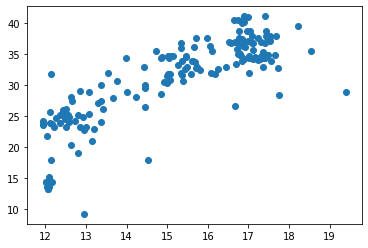

In [17]:
# plot
import matplotlib.pyplot as plt
plt.scatter(-np.log(df_join['pvalue']), -np.log(df_join['pval_trc']))

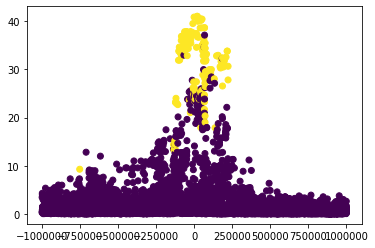

In [18]:
plt.scatter(df_g['tss_distance'], -np.log(df_g['pval_trc']), c = np.isin(df_g['tss_distance'], df_join['tss_distance']).tolist())